# GPQA-Diamond w/ Compression Analysis
### By Bryan Sukidi

## Overview

=== Overall Statistics ===
Total evaluations: 1183
Overall accuracy: 56.97%

=== Accuracy by Compression ===
                  is_correct       
                       count   mean
compression_index                  
0                        198  0.621
1                        197  0.650
2                        197  0.589
3                        197  0.553
4                        197  0.528
5                        197  0.477

=== Character Count Reduction ===
                   percent_of_original
compression_index                     
0                                100.0
1                                 55.6
2                                 42.4
3                                 33.1
4                                 24.7
5                                 14.3


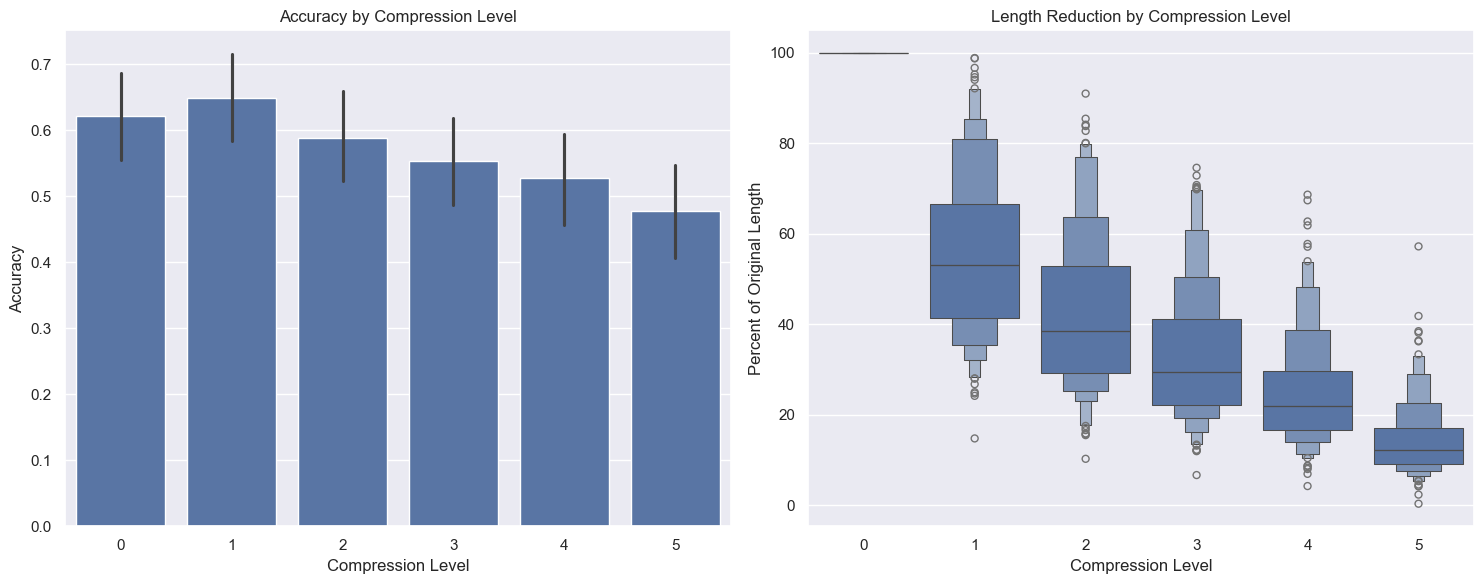

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()  

timestamp = "20250130_195708"
combined_df = pd.read_csv(f"../results/results_{timestamp}_final.csv")

# Basic statistics
print("=== Overall Statistics ===")
print(f"Total evaluations: {len(combined_df)}")
print(f"Overall accuracy: {combined_df['is_correct'].mean():.2%}")

# Accuracy by compression level
print("\n=== Accuracy by Compression ===")
compression_accuracy = combined_df.groupby('compression_index').agg({
    'is_correct': ['count', 'mean']
}).round(3)
print(compression_accuracy)

# Character count reduction
print("\n=== Character Count Reduction ===")
char_reduction = combined_df.groupby('compression_index').agg({
    'percent_of_original': 'mean'
}).round(1)
print(char_reduction)

# Summary plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Simple bar plot for accuracy with palette
sns.barplot(data=combined_df, x='compression_index', y='is_correct', ax=ax1)
ax1.set_title('Accuracy by Compression Level')
ax1.set_xlabel('Compression Level')
ax1.set_ylabel('Accuracy')

# Compression levels with palette
sns.boxenplot(data=combined_df, x='compression_index', y='percent_of_original', ax=ax2)
ax2.set_title('Length Reduction by Compression Level')
ax2.set_xlabel('Compression Level')
ax2.set_ylabel('Percent of Original Length')

plt.tight_layout()
plt.show()

## Baseline Accuracy

In [19]:
# Get record_ids where baseline (compression_index 0) was correct
correct_baseline_ids = combined_df[
    (combined_df['compression_index'] == 0) & 
    (combined_df['is_correct'] == True)
]['record_id'].unique()

# Filter the dataframe for only those records
filtered_df = combined_df[combined_df['record_id'].isin(correct_baseline_ids)].copy()

# Calculate baseline accuracy and diffs for filtered dataset
baseline_accuracy = filtered_df[filtered_df['compression_index'] == 0].groupby('record_id')['is_correct'].first()
filtered_df['baseline_correct'] = filtered_df['record_id'].map(baseline_accuracy)
filtered_df['accuracy_diff'] = (filtered_df['is_correct'].astype(int) - 
                              filtered_df['baseline_correct'].astype(int)) * 100

# Create figure with two subplots
fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(12, 6))

# 1. Line plot for accuracy
sns.lineplot(
    data=filtered_df,
    x='compression_index',
    y='is_correct',
    marker='o',
    ax=ax1
)
ax1.set_title('Accuracy by Compression Level\n(Baseline Correct Only)')
ax1.set_xlabel('Compression Level')
ax1.set_ylabel('Accuracy')

# Add value labels
for x, y in zip(filtered_df.groupby('compression_index')['compression_index'].first(), 
                filtered_df.groupby('compression_index')['is_correct'].mean()):
    ax1.text(x, y, f'{y:.3f}', ha='center', va='bottom')

# 2. Performance difference from baseline
sns.barplot(
    data=filtered_df[filtered_df['compression_index'] > 0],  # Exclude baseline
    x='compression_index',
    y='accuracy_diff',
    ax=ax3,
    ci=None  # Remove error bars
)
ax3.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax3.set_title('Accuracy Change from Baseline\n(Baseline Correct Only)')
ax3.set_xlabel('Compression Level')
ax3.set_ylabel('Change in Accuracy (%)')

# Add value labels on bars
for i, v in enumerate(filtered_df[filtered_df['compression_index'] > 0].groupby('compression_index')['accuracy_diff'].mean()):
    ax3.text(i, v, f'{v:.1f}%', ha='center', va='bottom' if v > 0 else 'top')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n=== Performance Summary (Baseline Correct Only) ===")
print(f"Number of questions correct at baseline: {len(correct_baseline_ids)}")
summary = filtered_df.groupby('compression_index').agg({
    'is_correct': ['mean', 'count'],
    'accuracy_diff': 'mean',
    'percent_of_original': 'mean'
}).round(3)
summary.columns = ['Accuracy', 'n', 'Change from Baseline (%)', 'Avg Length (%)']
print(summary)

C:\Users\Bryan Sukidi\AppData\Local\Temp\ipykernel_10552\2501926467.py:37: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(



=== Performance Summary (Baseline Correct Only) ===
Number of questions correct at baseline: 123
                   Accuracy    n  Change from Baseline (%)  Avg Length (%)
compression_index                                                         
0                       1.0  123                       0.0           100.0


## Display questions

In [ ]:
from IPython.display import HTML
import random

def display_sampled_questions(df, n_samples=5, seed=None):
    if seed is not None:
        random.seed(seed)
    
    # Get random sample of unique record_ids
    all_record_ids = df[df['compression_index'] == 0]['record_id'].unique()
    sampled_ids = random.sample(list(all_record_ids), min(n_samples, len(all_record_ids)))
    
    html_content = """
    <style>
        .question-card {
            border: 1px solid #ddd;
            margin: 20px 0;
            padding: 15px;
            border-radius: 8px;
            background-color: #f9f9f9;
        }
        .compression-level {
            margin: 10px 0;
            padding: 10px;
            background-color: white;
            border-radius: 4px;
            border-left: 4px solid #007bff;
        }
        .correct {
            color: #28a745;
            font-weight: bold;
        }
        .incorrect {
            color: #dc3545;
            font-weight: bold;
        }
        .stats {
            color: #6c757d;
            font-size: 0.9em;
        }
        .question-text {
            font-size: 1.1em;
            margin: 10px 0;
        }
        .answer-choice {
            margin: 5px 0;
            padding: 5px;
        }
        .selected {
            background-color: #e2e3e5;
            border-radius: 4px;
        }
    </style>
    """
    
    for record_id in sampled_ids:
        question_data = df[df['record_id'] == record_id].sort_values('compression_index')
        
        # Start question card
        html_content += f"""
        <div class="question-card">
            <h3>Question ID: {record_id}</h3>
        """
        
        # Add each compression level
        for _, row in question_data.iterrows():
            status_class = "correct" if row['is_correct'] else "incorrect"
            compression_level = row['compression_index']
            
            html_content += f"""
            <div class="compression-level">
                <h4>Compression Level {compression_level} 
                    <span class="stats">
                        ({row['percent_of_original']:.1f}% of original, 
                        {row['compressed_char_count']} chars)
                    </span>
                </h4>
                <div class="question-text">{row['question']}</div>
                <div class="answer-choices">
            """
            
            # Add answer choices (assuming they're in the format "A: answer")
            predicted = row['predicted_letter']
            correct = row['correct_letter']
            
            # Create answer choice display
            answers = {
                'A': row['predicted_answer'],  # You might need to adjust this based on your data structure
                'B': "Option B",  # You'll need to add these to your dataset
                'C': "Option C",
                'D': "Option D"
            }
            
            for letter, answer in answers.items():
                classes = []
                if letter == predicted:
                    classes.append("selected")
                
                status = ""
                if letter == predicted:
                    status = "✓" if row['is_correct'] else "✗"
                    if letter == correct:
                        status += " (Correct)"
                elif letter == correct and not row['is_correct']:
                    status = "(Correct Answer)"
                
                html_content += f"""
                <div class="answer-choice {' '.join(classes)}">
                    {letter}: {answer} {status}
                </div>
                """
            
            html_content += f"""
                </div>
                <div class="{status_class}">
                    Result: {"Correct" if row['is_correct'] else "Incorrect"}
                </div>
            </div>
            """
        
        html_content += "</div>"
    
    return HTML(html_content)


display_sampled_questions(combined_df, n_samples=1)

In [ ]:
display_sampled_questions(combined_df, n_samples=1)

## Find instances where index 0 wrong, index 1 correct 

In [ ]:
improved_cases

In [5]:
# Filter for compression indices 0 and 1
df_01 = combined_df[combined_df['compression_index'].isin([0, 1])]

# Get length_group information
length_info = df_01[['record_id', 'length_group']].drop_duplicates()

# Pivot to compare correctness side by side
comparison_df = df_01.pivot(
    index='record_id',
    columns='compression_index',
    values=['is_correct', 'question', 'predicted_answer', 'correct_answer']
)

# Rename columns for clarity
comparison_df.columns = [
    'original_correct', 'compressed_correct',
    'original_text', 'compressed_text',
    'original_predicted', 'compressed_predicted',
    'original_correct_ans', 'compressed_correct_ans'
]

# Add length_group back to the comparison_df
comparison_df = comparison_df.join(length_info.set_index('record_id'))

# Find cases where original was wrong but compressed was right
improved_cases = comparison_df[
    (~comparison_df['original_correct']) & 
    (comparison_df['compressed_correct'])
]

print(f"\nFound {len(improved_cases)} cases where compression improved accuracy!")
print("\nAnalysis by Length Group:")
print(improved_cases.groupby('length_group').size())

print("\nDetailed Analysis:")
print("-" * 80)

for idx, row in improved_cases.iterrows():
    print(f"\nRecord ID: {idx}")
    print(f"Length Group: {row['length_group']}")
    print("\nORIGINAL VERSION (Wrong):")
    print(f"Question: {row['original_text']}")
    print(f"Predicted: {row['original_predicted']}")
    print(f"Correct: {row['original_correct_ans']}")
    
    print("\nCOMPRESSED VERSION (Correct):")
    print(f"Question: {row['compressed_text']}")
    print(f"Predicted: {row['compressed_predicted']}")
    print(f"Correct: {row['compressed_correct_ans']}")
    
    print("\n" + "-" * 80)

# Additional statistics by length group
if len(improved_cases) > 0:
    print("\nCharacter count analysis by length group:")
    char_counts = df_01[df_01['record_id'].isin(improved_cases.index)].groupby(['length_group', 'compression_index']).agg({
        'compressed_char_count': ['mean', 'min', 'max'],
        'percent_of_original': ['mean', 'min', 'max']
    }).round(2)
    print(char_counts)


Found 31 cases where compression improved accuracy!

Analysis by Length Group:
length_group
Short        11
Medium        6
Long         11
Very Long     3
dtype: int64

Detailed Analysis:
--------------------------------------------------------------------------------

Record ID: rec9GugrngvsQR99A
Length Group: Long

ORIGINAL VERSION (Wrong):
Question: Compounds that have the same molecular formula but are different in their structural arrangement are known as isomers. Isomers have two types, constitutional isomers and stereoisomers. Constitutional isomers have the same molecular formula but differ in their structures. In stereoisomers, molecules are connected in the same way, but their arrangements in space are different.
Among the given compounds (benzoquinone & cyclohexane-1,3,5-trione) the compound that does not show tautomerism (A) and among methyl 2-hydroxypropanoate and dimethyl fumarate which one will show optical isomerism (B).
Predicted: A = cyclohexane-1,3,5-trione, B = me

C:\Users\Bryan Sukidi\AppData\Local\Temp\ipykernel_10552\3376531502.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(improved_cases.groupby('length_group').size())
C:\Users\Bryan Sukidi\AppData\Local\Temp\ipykernel_10552\3376531502.py:56: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  char_counts = df_01[df_01['record_id'].isin(improved_cases.index)].groupby(['length_group', 'compression_index']).agg({


In [11]:
improved_cases.index

Index(['rec9GugrngvsQR99A', 'rec9W28HgpEUeUN8k', 'recA1i5ZAh0Uzclxp',
       'recD8oX1KevFbl7bL', 'recDDxpS9s8cwkqfq', 'recDj2Y2BbtV02Wv5',
       'recJZ3QEfRKjYw9a7', 'recK9F5aqdaybl8bb', 'recKm6LNWykGapmCr',
       'recLB0EkQ54bYVhnd', 'recOYsaYs6RmtlTDy', 'recOkA2zsy4GSMD9R',
       'recRZjaElf8ft7xTq', 'recUBgVlkKzcRPDdK', 'recWPMm91mGDLXONm',
       'recZWeueB7lSPR6wN', 'reca44yABeO2fx7UB', 'recaXdGn3FAIkxLGM',
       'recakFKZioXUuldcd', 'recb4cGsC6BJUCU3V', 'recfTlTMjZBuOducT',
       'recgC4GJ8wUemlUQD', 'recn3NhOhqAPLda16', 'recnGEpF1srQpaqWq',
       'recrNbtgTNoabJJi6', 'rect4iLrSfUwkNTno', 'recuyeuT5rQ6qDt8F',
       'recv7GsQg3f0fvB1f', 'recyl3usDqb7ruXJx', 'reczQ4I0VpENdMtIj',
       'reczzzihL7btBH7RO'],
      dtype='object', name='record_id')

## Models often under-generate characters when compressed

NameError: name 'df' is not defined

In [ ]:
# Create mapping of compression index to target percent
target_map = {
    0: 100,
    1: 90,
    2: 80,
    3: 60,
    4: 40,
    5: 20
}

# Add target_percent column using map
combined_df['target_percent'] = combined_df['compression_index'].map(target_map)
combined_df['target_char_count'] = combined_df['original_char_count'] * combined_df['target_percent'] / 100

plt.figure(figsize=(12, 8))

# Simple bar plot showing average actual percent vs target percent
summary_df = combined_df.groupby('compression_index').agg({
    'target_percent': 'first',
    'percent_of_original': 'mean'
}).reset_index()

# Plot bars side by side
x = range(len(summary_df))
width = 0.35

plt.bar(x, summary_df['target_percent'], width, label='Target Length', alpha=0.7)
plt.bar([i + width for i in x], summary_df['percent_of_original'], width, label='Actual Length', alpha=0.7)

plt.title('Target vs Actual Compression Length')
plt.xlabel('Compression Level')
plt.ylabel('Percent of Original Length')
plt.legend()

# Add value labels on the bars
for i, row in summary_df.iterrows():
    plt.text(i, row['target_percent'], f"{row['target_percent']}%", ha='center', va='bottom')
    plt.text(i + width, row['percent_of_original'], f"{row['percent_of_original']:.1f}%", ha='center', va='bottom')

plt.xticks([i + width/2 for i in x], summary_df['compression_index'])



plt.tight_layout()
plt.show()

## Assign length group

In [3]:
def assign_length_group(char_count):
    if char_count < 250:  
        return 'Short'
    elif char_count < 500: 
        return 'Medium'
    elif char_count < 750:  
        return 'Long'
    else:  # Multi-paragraph
        return 'Very Long'

# Define the order we want
length_order = ['Short', 'Medium', 'Long', 'Very Long']

# Add length groups to main dataframe
original_questions = combined_df[combined_df['compression_index'] == 0]
length_groups = original_questions[['record_id', 'original_char_count']].copy()
length_groups['length_group'] = pd.Categorical(
    length_groups['original_char_count'].apply(assign_length_group),
    categories=length_order,
    ordered=True
)

# Merge back to main dataframe
combined_df = combined_df.merge(length_groups[['record_id', 'length_group']], on='record_id')

In [4]:
# Get original questions only
original_questions = combined_df[combined_df['compression_index'] == 0]

# Create histogram with length groups
plt.figure(figsize=(12, 6))

# Plot histogram with colors by length group
sns.histplot(
    data=original_questions, 
    x='original_char_count', 
    bins=50,
    hue='length_group',
    hue_order=['Short', 'Medium', 'Long', 'Very Long'],
    multiple="stack"  # Stack the bars to show total height
)

plt.title('Distribution of Original Question Lengths')
plt.xlabel('Character Count')
plt.ylabel('Number of Questions')

# Add basic statistics as text
stats = original_questions['original_char_count'].describe()
stats_text = f"Mean: {stats['mean']:.1f}\n"
stats_text += f"Std: {stats['std']:.1f}\n"
stats_text += f"Min: {stats['min']:.0f}\n"
stats_text += f"25%: {stats['25%']:.0f}\n"
stats_text += f"50%: {stats['50%']:.0f}\n"
stats_text += f"75%: {stats['75%']:.0f}\n"
stats_text += f"Max: {stats['max']:.0f}"

plt.text(0.95, 0.95, stats_text,
         transform=plt.gca().transAxes,
         verticalalignment='top',
         horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Add vertical lines at the cutoff points
cutoffs = [100, 250, 500, 750]
for cutoff in cutoffs:
    plt.axvline(x=cutoff, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## Identify cases where model imporved

### Breakdown by Original Question Length

In [ ]:
# Calculate summary with error
summary_all = combined_df.groupby(['length_group', 'compression_index']).agg({
    'target_percent': 'first',
    'percent_of_original': 'mean'
}).reset_index()

# Calculate error (negative means undergeneration)
summary_all['error'] = summary_all['percent_of_original'] - summary_all['target_percent']

plt.figure(figsize=(12, 8))

# Create line plot for each length group
sns.lineplot(
    data=summary_all,
    x='compression_index',
    y='error',
    hue='length_group',
    marker='o',
    markersize=8
)

# Add horizontal line at 0
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

plt.title('Compression Error by Question Length')
plt.xlabel('Target Compression (% of Original)')
plt.ylabel('Error (Actual % - Target %)')
plt.legend(title='Question Length', bbox_to_anchor=(1.05, 1))

# Add value labels
for length_group in summary_all['length_group'].unique():
    group_data = summary_all[summary_all['length_group'] == length_group]
    for _, row in group_data.iterrows():
        plt.text(row['compression_index'], row['error'], f"{row['error']:.1f}%", 
                ha='center', va='bottom')

plt.xticks(range(6), ['100%', '90%', '80%', '60%', '40%', '20%'])

plt.tight_layout()
plt.show()

In [ ]:
# Create a figure with multiple subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))

# Plot 1: Original vs Compressed
sns.scatterplot(
    data=combined_df[combined_df['compression_index'] != 0],
    x='original_char_count',
    y='compressed_char_count',
    hue='compression_index',
    alpha=0.5,
    ax=ax1
)
ax1.set_title('Original vs Compressed Character Count')
ax1.set_xlabel('Original Character Count')
ax1.set_ylabel('Compressed Character Count')

# Plot 2: Original vs Percent of Original
sns.scatterplot(
    data=combined_df,
    x='original_char_count',
    y='percent_of_original',
    hue='compression_index',
    alpha=0.5,
    ax=ax2
)
ax2.set_title('Original Length vs Achieved Compression')
ax2.set_xlabel('Original Character Count')
ax2.set_ylabel('Percent of Original Length')
ax2.axhline(y=100, color='gray', linestyle='--', alpha=0.5)

# Plot 3: Target vs Actual Percent
sns.violinplot(
    data=combined_df,
    x='target_percent',
    y='percent_of_original',
    hue='compression_index',
    alpha=0.5,
    ax=ax3
)
ax3.set_title('Target vs Achieved Compression')
ax3.set_xlabel('Target Percent')
ax3.set_ylabel('Actual Percent of Original')
ax3.plot([0, 0.9], [0, 1], 'gray', linestyle='--', alpha=0.5)

# Plot 4: Target vs Actual Character Count
sns.scatterplot(
    data=combined_df[combined_df['compression_index'] != 0],
    x='target_char_count',
    y='compressed_char_count',
    hue='compression_index',
    alpha=0.5,
    ax=ax4
)
ax4.set_title('Target vs Actual Character Count')
ax4.set_xlabel('Target Character Count')
ax4.set_ylabel('Actual Compressed Count')

# Adjust layout and show
plt.tight_layout()
plt.show()

In [ ]:
# Create simple scatter plot with compression level as color
sns.scatterplot(
    data=combined_df,
    x='original_char_count',
    y='compressed_char_count',
    hue='compression_index',
    alpha=0.5
)

plt.title('Original vs Compressed Character Count')
plt.xlabel('Original Character Count')
plt.ylabel('Compressed Character Count')

# Move legend outside
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Compression Level')

plt.tight_layout()
plt.show()

Let's look

C:\Users\Bryan Sukidi\AppData\Local\Temp\ipykernel_10552\217418081.py:23: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = df_analysis.pivot_table(


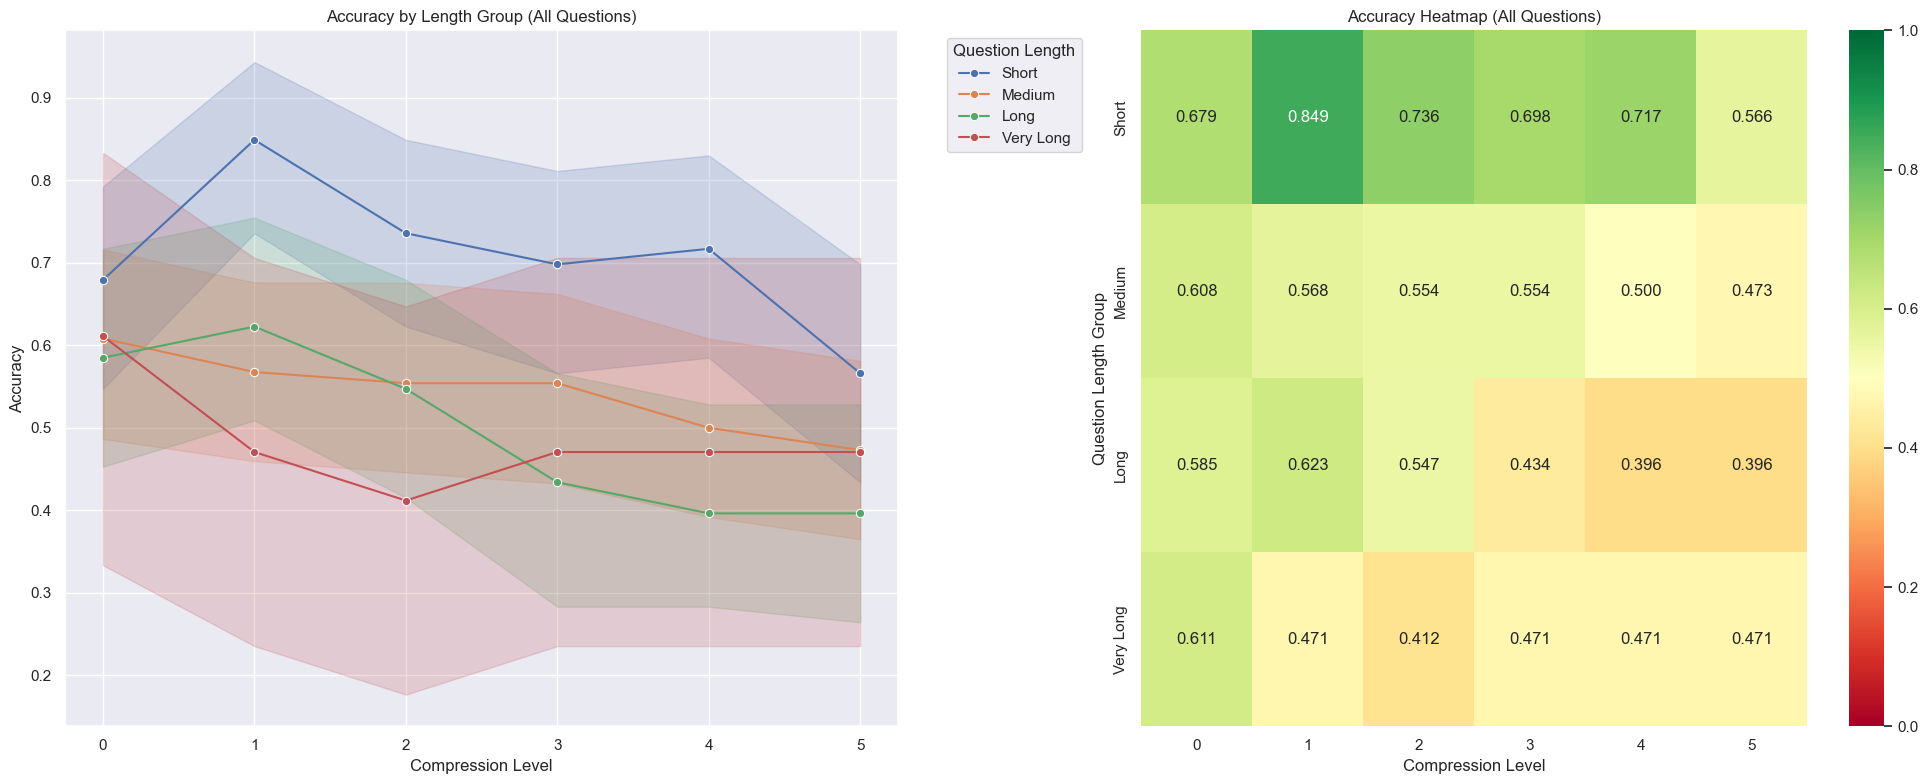

C:\Users\Bryan Sukidi\AppData\Local\Temp\ipykernel_10552\217418081.py:74: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data_filtered = filtered_df.pivot_table(


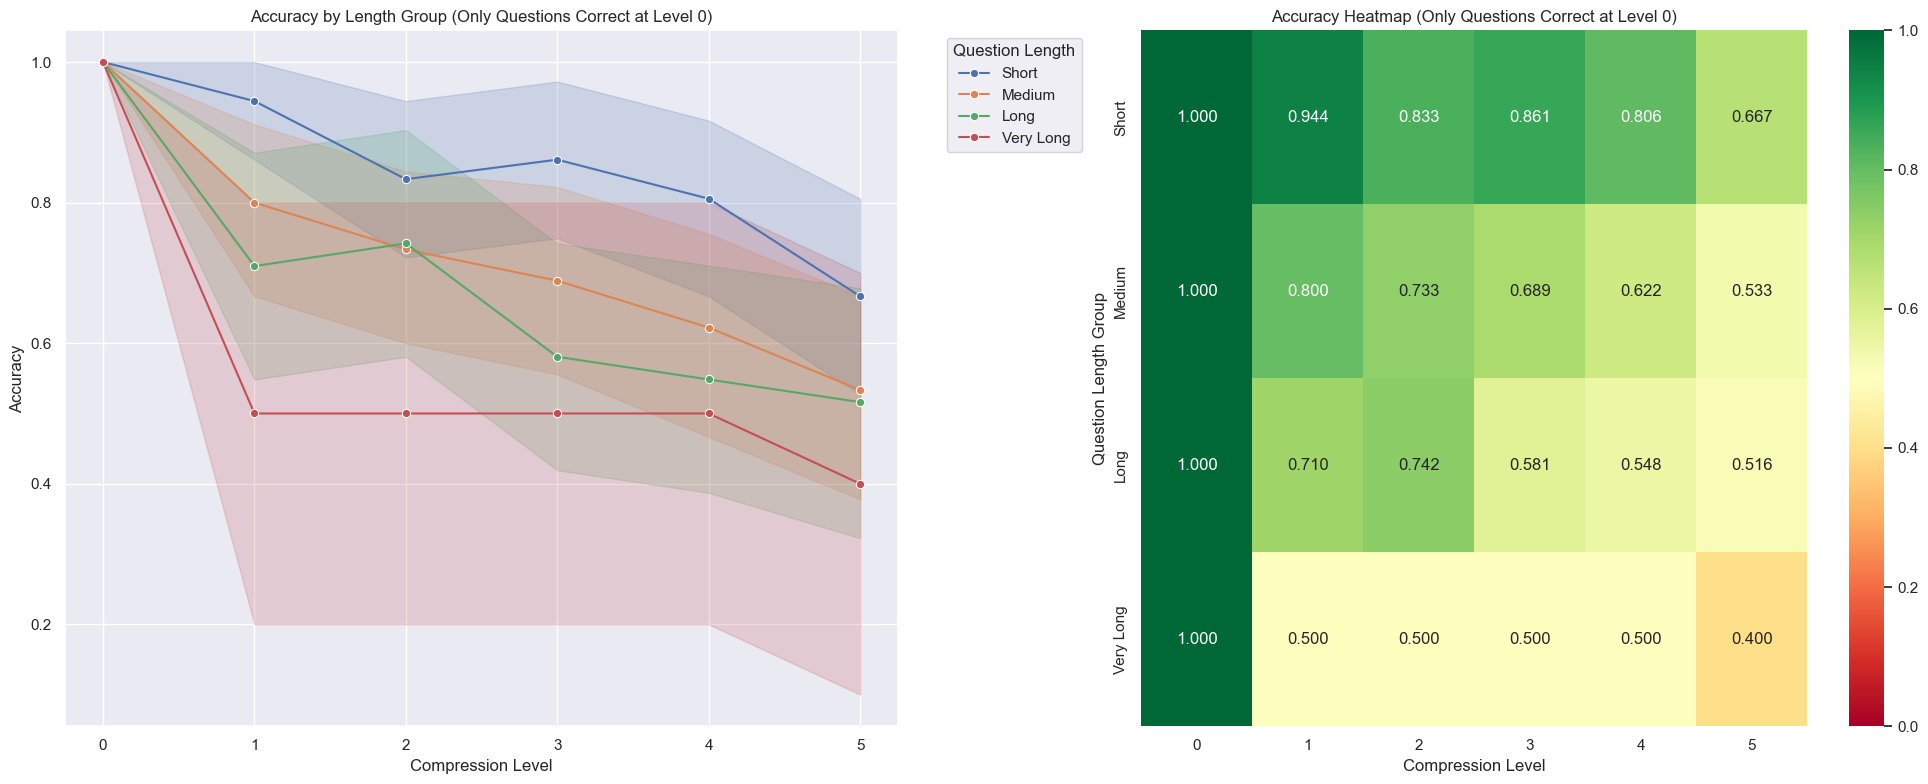

In [13]:
# Original Analysis
df_analysis = combined_df.copy()  # Create a copy for analysis

# Create figure with subplots for original analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot 1: Line plot
sns.lineplot(
    data=df_analysis,
    x='compression_index',
    y='is_correct',
    hue='length_group',
    marker='o',
    ax=ax1
)

ax1.set_title('Accuracy by Length Group (All Questions)')
ax1.set_xlabel('Compression Level')
ax1.set_ylabel('Accuracy')
ax1.legend(title='Question Length', bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot 2: Heatmap
heatmap_data = df_analysis.pivot_table(
    values='is_correct',
    index='length_group',
    columns='compression_index',
    aggfunc='mean'
)

sns.heatmap(
    heatmap_data, 
    annot=True, 
    fmt='.3f', 
    cmap='RdYlGn',
    center=0.5,
    vmin=0,
    vmax=1,
    ax=ax2
)
ax2.set_title('Accuracy Heatmap (All Questions)')
ax2.set_xlabel('Compression Level')
ax2.set_ylabel('Question Length Group')

plt.tight_layout()
plt.show()

# Filtered Analysis (only questions correct at compression_index 0)
correct_at_zero = df_analysis[
    (df_analysis['compression_index'] == 0) & 
    (df_analysis['is_correct'] == 1)
]['record_id'].unique()

filtered_df = df_analysis[df_analysis['record_id'].isin(correct_at_zero)].copy()

# Create figure with subplots for filtered analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot 1: Line plot for filtered data
sns.lineplot(
    data=filtered_df,
    x='compression_index',
    y='is_correct',
    hue='length_group',
    marker='o',
    ax=ax1
)

ax1.set_title('Accuracy by Length Group (Only Questions Correct at Level 0)')
ax1.set_xlabel('Compression Level')
ax1.set_ylabel('Accuracy')
ax1.legend(title='Question Length', bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot 2: Heatmap for filtered data
heatmap_data_filtered = filtered_df.pivot_table(
    values='is_correct',
    index='length_group',
    columns='compression_index',
    aggfunc='mean'
)

sns.heatmap(
    heatmap_data_filtered, 
    annot=True, 
    fmt='.3f', 
    cmap='RdYlGn',
    center=0.5,
    vmin=0,
    vmax=1,
    ax=ax2
)
ax2.set_title('Accuracy Heatmap (Only Questions Correct at Level 0)')
ax2.set_xlabel('Compression Level')
ax2.set_ylabel('Question Length Group')

plt.tight_layout()
plt.show()

## Filtering Based on Correctness

Let's look specifically at the questions where the model was correct on the original.

In [ ]:
# First, identify questions that were correct at compression_index 0
correct_at_zero = combined_df[
    (combined_df['compression_index'] == 0) & 
    (combined_df['is_correct'] == 1)
]['record_id'].unique()

# Filter the dataframe to only include these questions
filtered_df = combined_df[combined_df['record_id'].isin(correct_at_zero)].copy()

# Get original questions to determine length groups
original_questions = filtered_df[filtered_df['compression_index'] == 0].copy()

# Create 5 length groups using quantiles
original_questions['length_group'] = pd.qcut(
    original_questions['original_char_count'],
    q=5,
    labels=['Very Short', 'Short', 'Medium', 'Long', 'Very Long']
)

# Add length groups back to main dataframe
length_groups = original_questions[['record_id', 'length_group']]
filtered_df = filtered_df.merge(length_groups, on='record_id')

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot 1: Line plot with confidence intervals
sns.lineplot(
    data=filtered_df,
    x='compression_index',
    y='is_correct',
    hue='length_group',
    marker='o',
    ci=95,
    ax=ax1
)

ax1.set_title('Accuracy by Length Group (Only Questions Correct at Level 0)')
ax1.set_xlabel('Compression Level')
ax1.set_ylabel('Accuracy')
ax1.legend(title='Question Length', bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot 2: Heatmap
heatmap_data = filtered_df.pivot_table(
    values='is_correct',
    index='length_group',
    columns='compression_index',
    aggfunc='mean'
)

sns.heatmap(
    heatmap_data, 
    annot=True, 
    fmt='.3f', 
    cmap='RdYlGn',
    center=0.5,
    vmin=0,
    vmax=1,
    ax=ax2
)
ax2.set_title('Accuracy Heatmap (Only Questions Correct at Level 0)')
ax2.set_xlabel('Compression Level')
ax2.set_ylabel('Question Length Group')

plt.tight_layout()
plt.show()

In [ ]:

# Create figure with multiple plots
fig = plt.figure(figsize=(20, 15))

# 1. Relative Performance Drop
ax1 = plt.subplot(2, 2, 1)
# Calculate relative performance drop compared to original
baseline_accuracy = combined_df[combined_df['compression_index'] == 0].groupby('record_id')['is_correct'].first()
relative_performance = combined_df.copy()
relative_performance['baseline_correct'] = relative_performance['record_id'].map(baseline_accuracy)
# Convert boolean to int before subtraction
relative_performance['performance_drop'] = relative_performance['is_correct'].astype(int) - relative_performance['baseline_correct'].astype(int)

sns.boxplot(
    data=relative_performance[relative_performance['compression_index'] > 0],
    x='compression_index',
    y='performance_drop'
)
ax1.set_title('Relative Performance Drop by Compression Level')
ax1.set_ylabel('Change in Accuracy (0 = No Change)')
ax1.axhline(y=0, color='r', linestyle='--')

# 2. Accuracy vs Compression Ratio
ax2 = plt.subplot(2, 2, 2)
sns.scatterplot(
    data=combined_df[combined_df['compression_index'] > 0],
    x='percent_of_original',
    y='is_correct',
    alpha=0.5
)
ax2.set_title('Accuracy vs Compression Ratio')
ax2.set_xlabel('Percent of Original Length')
ax2.set_ylabel('Accuracy')

# 3. Performance Deterioration Rate
ax3 = plt.subplot(2, 2, 3)
# Calculate deterioration rate for each question
deterioration_rates = []
for record_id in combined_df['record_id'].unique():
    question_data = combined_df[combined_df['record_id'] == record_id].sort_values('compression_index')
    if len(question_data) > 1:
        # Calculate slope of accuracy vs compression level
        x = question_data['compression_index']
        y = question_data['is_correct'].astype(float)  # Convert to float for slope calculation
        rate = np.polyfit(x, y, 1)[0]
        deterioration_rates.append({
            'record_id': record_id,
            'deterioration_rate': rate,
            'original_length': question_data['original_char_count'].iloc[0]
        })

deterioration_df = pd.DataFrame(deterioration_rates)
# Create length groups for deterioration analysis
deterioration_df['length_group'] = pd.qcut(
    deterioration_df['original_length'],
    q=5,
    labels=['Very Short', 'Short', 'Medium', 'Long', 'Very Long']
)

sns.boxplot(
    data=deterioration_df,
    x='length_group',
    y='deterioration_rate'
)
ax3.set_title('Rate of Performance Deterioration by Length Group')
ax3.set_ylabel('Deterioration Rate (more negative = faster deterioration)')

# 4. Survival Analysis
ax4 = plt.subplot(2, 2, 4)
# Calculate "survival rate" (questions that maintain accuracy)
survival_data = combined_df.groupby('compression_index').agg({
    'is_correct': 'mean',
    'percent_of_original': 'mean'
}).reset_index()

sns.lineplot(
    data=survival_data,
    x='percent_of_original',
    y='is_correct',
    marker='o'
)
ax4.set_title('Performance "Survival Rate" vs Compression')
ax4.set_xlabel('Average Percent of Original Length')
ax4.set_ylabel('Accuracy')

plt.tight_layout()
plt.show()

# Print some statistics
print("\nDeterioration Statistics:")
print("\nAverage deterioration rate by length group:")
print(deterioration_df.groupby('length_group')['deterioration_rate'].mean().round(4))

print("\nPerformance drop at each compression level:")
for idx in range(1, 6):
    baseline = combined_df[combined_df['compression_index'] == 0]['is_correct'].mean()
    compressed = combined_df[combined_df['compression_index'] == idx]['is_correct'].mean()
    print(f"Compression level {idx}: {(baseline - compressed):.3f} drop from baseline")

Index(['record_id', 'compression_index', 'question_id', 'question',
       'predicted_letter', 'predicted_answer', 'correct_letter',
       'correct_answer', 'is_correct', 'original_char_count',
       'compressed_char_count', 'percent_of_original', 'process_id'],
      dtype='object')

In [ ]:
# Load GPQA diamond dataset
gpqa_df = pd.read_csv('../datasets/gpqa_diamond.csv')

# Merge datasets
merged_df = combined_df.merge(
    gpqa_df[['Record ID', 'High-level domain', 'Subdomain']], 
    left_on='record_id',
    right_on='Record ID',
    how='left'
)

# Create figure with multiple plots
fig = plt.figure(figsize=(20, 15))

# 1. Performance Drop by Domain
ax1 = plt.subplot(2, 2, 1)
sns.lineplot(
    data=merged_df,
    x='compression_index',
    y='is_correct',
    hue='High-level domain',
    marker='o',
    ci=95
)
ax1.set_title('Accuracy by Domain and Compression Level')
ax1.set_xlabel('Compression Level')
ax1.set_ylabel('Accuracy')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 2. Relative Performance Drop by Domain
ax2 = plt.subplot(2, 2, 2)
baseline_accuracy = merged_df[merged_df['compression_index'] == 0].groupby('record_id')['is_correct'].first()
relative_performance = merged_df.copy()
relative_performance['baseline_correct'] = relative_performance['record_id'].map(baseline_accuracy)
relative_performance['performance_drop'] = relative_performance['is_correct'].astype(int) - relative_performance['baseline_correct'].astype(int)

sns.boxplot(
    data=relative_performance[relative_performance['compression_index'] > 0],
    x='compression_index',
    y='performance_drop',
    hue='High-level domain'
)
ax2.set_title('Performance Drop by Domain')
ax2.set_ylabel('Change in Accuracy (0 = No Change)')
ax2.axhline(y=0, color='r', linestyle='--')

# 3. Heatmap of Domain Performance
ax3 = plt.subplot(2, 2, 3)
heatmap_data = merged_df.pivot_table(
    values='is_correct',
    index='Subdomain',
    columns='compression_index',
    aggfunc='mean'
)
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt='.3f',
    cmap='RdYlGn',
    center=0.5,
    vmin=0,
    vmax=1
)
ax3.set_title('Accuracy Heatmap by Subdomain and Compression Level')

# 4. Subdomain Analysis
ax4 = plt.subplot(2, 2, 4)
# Get top N subdomains by number of questions
top_subdomains = merged_df[merged_df['compression_index'] == 0]['Subdomain'].value_counts().head(8).index
subdomain_data = merged_df[merged_df['Subdomain'].isin(top_subdomains)]

sns.lineplot(
    data=subdomain_data,
    x='compression_index',
    y='is_correct',
    hue='Subdomain',
    marker='o',
    ci=95
)
ax4.set_title('Accuracy by Top Subdomains')
ax4.set_xlabel('Compression Level')
ax4.set_ylabel('Accuracy')
ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Print detailed statistics
print("\nPerformance Deterioration by Domain:")
for domain in merged_df['High-level domain'].unique():
    domain_data = merged_df[merged_df['High-level domain'] == domain]
    baseline = domain_data[domain_data['compression_index'] == 0]['is_correct'].mean()
    print(f"\n{domain}:")
    print(f"Baseline accuracy: {baseline:.3f}")
    for idx in range(1, 6):
        compressed = domain_data[domain_data['compression_index'] == idx]['is_correct'].mean()
        drop = baseline - compressed
        print(f"Compression {idx}: {drop:.3f} drop ({compressed:.3f} accuracy)")

# Calculate "resilience score" by domain
print("\nDomain Resilience Scores (average performance retention):")
domain_resilience = []
for domain in merged_df['High-level domain'].unique():
    domain_data = merged_df[merged_df['High-level domain'] == domain]
    baseline = domain_data[domain_data['compression_index'] == 0]['is_correct'].mean()
    compressed_accuracy = domain_data[domain_data['compression_index'] > 0]['is_correct'].mean()
    resilience_score = compressed_accuracy / baseline if baseline > 0 else 0
    domain_resilience.append({
        'Domain': domain,
        'Resilience': resilience_score,
        'Baseline': baseline,
        'Compressed': compressed_accuracy
    })

resilience_df = pd.DataFrame(domain_resilience).sort_values('Resilience', ascending=False)
print(resilience_df.round(3))

In [ ]:
# Filter for only compression_index 0
original_df = merged_df[merged_df['compression_index'] == 0]

# Total statistics
print("=== Total Statistics (Uncompressed Only) ===")
total_stats = {
    'Total Questions': len(original_df),
    'Overall Accuracy': original_df['is_correct'].mean().round(3),
    'Standard Deviation': original_df['is_correct'].std().round(3)
}
print(pd.Series(total_stats))
print("\n" + "="*50)

# High-level domain summary
print("\n=== High-Level Domain Summary (Uncompressed Only) ===")
domain_summary = original_df.groupby('High-level domain').agg({
    'record_id': 'count',  # Count of questions
    'is_correct': ['mean', 'std']  # Accuracy mean and std
}).round(3)

# Rename columns for clarity
domain_summary.columns = ['Count', 'Accuracy', 'Std']
print(domain_summary.sort_values('Count', ascending=False))

# Subdomain summary
print("\n=== Subdomain Summary (Uncompressed Only) ===")
subdomain_summary = original_df.groupby('Subdomain').agg({
    'record_id': 'count',  # Count of questions
    'is_correct': ['mean', 'std']  # Accuracy mean and std
}).round(3)

# Rename columns for clarity
subdomain_summary.columns = ['Count', 'Accuracy', 'Std']
print(subdomain_summary.sort_values('Count', ascending=False))

In [ ]:
combined_df

## Performance Difference w.r.t Question Length and Compression

In [ ]:
# Previous code remains the same until the plotting part

# Calculate sample sizes
sample_sizes = perf_diff_df[perf_diff_df['compression_index'] > 0].groupby('length_group').size()
compression_sizes = perf_diff_df[perf_diff_df['compression_index'] > 0].groupby(['length_group', 'target_percent']).size()

plt.figure(figsize=(15, 8))

# Create grouped bar plot with ci=None to remove error bars
sns.barplot(
    data=perf_diff_df[perf_diff_df['compression_index'] > 0],  # Exclude baseline
    x='length_group',
    y='performance_diff',
    hue='target_percent',
    order=['Short', 'Medium', 'Long', 'Very Long'],
    ci=None  # Remove error bars
)

plt.axhline(y=0, color='black', linestyle='-', alpha=0.2)
plt.title('Performance Difference from Baseline by Question Length and Target Length')
plt.xlabel('Question Length Group\n' + '\n'.join([f'{group}: n={n}' for group, n in sample_sizes.items()]))
plt.ylabel('Difference in Accuracy from Baseline (%)')

# Add value labels on the bars
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%.1f%%', padding=3)

plt.legend(title='Compression Level', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

# Print summary statistics with sample sizes
print("\nAverage Performance Drop by Length Group and Compression Level:")
summary_with_n = pd.DataFrame({
    'Performance Diff': perf_diff_df[perf_diff_df['compression_index'] > 0].groupby(
        ['length_group', 'target_percent'])['performance_diff'].mean().round(1),
    'n': compression_sizes
})
print(summary_with_n)

In [ ]:
combined_df

In [ ]:
# Load and merge domain information
gpqa_df = pd.read_csv('../datasets/gpqa_diamond.csv')
perf_diff_df = perf_diff_df.merge(
    gpqa_df[['Record ID', 'High-level domain', 'Subdomain']], 
    left_on='record_id',
    right_on='Record ID',
    how='left'
)

# Create figure with subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))

# 1. Length Impact
sns.barplot(
    data=perf_diff_df[perf_diff_df['compression_index'] > 0],
    x='length_group',
    y='performance_diff',
    hue='target_percent',
    order=['Short', 'Medium', 'Long', 'Very Long'],
    ax=ax1
)
ax1.axhline(y=0, color='black', linestyle='-', alpha=0.2)
ax1.set_title('Performance Drop by Question Length')
ax1.set_xlabel('Question Length')
ax1.set_ylabel('Accuracy Change from Baseline (%)')

# 2. Domain Resilience
sns.barplot(
    data=perf_diff_df[perf_diff_df['compression_index'] > 0],
    x='High-level domain',
    y='performance_diff',
    hue='target_percent',
    ax=ax2
)
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.2)
ax2.set_title('Performance Drop by Domain')
ax2.set_xlabel('Domain')
ax2.tick_params(axis='x', rotation=45)
ax2.set_ylabel('Accuracy Change from Baseline (%)')

# 3. Compression Severity Curve
sns.lineplot(
    data=perf_diff_df,
    x='compression_index',
    y='performance_diff',
    hue='length_group',
    marker='o',
    ax=ax3
)
ax3.axhline(y=0, color='black', linestyle='-', alpha=0.2)
ax3.set_title('Performance Drop by Compression Level')
ax3.set_xlabel('Compression Level')
ax3.set_ylabel('Accuracy Change from Baseline (%)')

# 4. Successful Cases Analysis
resilient_cases = perf_diff_df[
    (perf_diff_df['compression_index'] == 5) &  # Most compressed
    (perf_diff_df['is_correct'] == 1) &         # Still correct
    (perf_diff_df['baseline_correct'] == 1)     # Was correct at baseline
]

success_by_domain = resilient_cases.groupby('High-level domain').size() / \
    perf_diff_df[perf_diff_df['compression_index'] == 5].groupby('High-level domain').size() * 100

success_by_domain.plot(kind='bar', ax=ax4)
ax4.set_title('Success Rate Under Heavy Compression (80% reduction)')
ax4.set_xlabel('Domain')
ax4.set_ylabel('% Questions Maintaining Accuracy')
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nKey Findings:")
print("\n1. Length Impact:")
length_summary = perf_diff_df[perf_diff_df['compression_index'] > 0].groupby(
    'length_group')['performance_diff'].mean().round(1)
print(length_summary)

print("\n2. Most Resilient Domains:")
domain_summary = perf_diff_df[perf_diff_df['compression_index'] > 0].groupby(
    'High-level domain')['performance_diff'].mean().sort_values(ascending=False).round(1)
print(domain_summary)

print("\n3. Compression Level Impact:")
level_summary = perf_diff_df.groupby('compression_index')['performance_diff'].mean().round(1)
print(level_summary)

print("\n4. Success Rate Under Heavy Compression:")
print(success_by_domain.round(1))